In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of 01060602previewen-02d.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_3.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Sample13.150.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image16 (3).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_4.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of close-up-of-alluvial-soil-as-a-texturebackground-JCB3RY.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_6 - Copy.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image15 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_26.png
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image16 (

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [4]:
# Preprocessing Function (CLAHE, HSV & Feature Enhancements)
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    
    r, g, b = cv2.split(image)
    r = cv2.addWeighted(r, 0.7, v_channel, 0.3, 0)
    g = cv2.addWeighted(g, 0.7, v_channel, 0.3, 0)
    b = cv2.addWeighted(b, 0.7, v_channel, 0.3, 0)
    
    processed_image = cv2.merge([r, g, b])
    processed_image = cv2.resize(processed_image, (224, 224))
    
    return Image.fromarray(processed_image)


In [5]:
# Transformations for Training & Testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# Dataset and DataLoader
data_dir = "/kaggle/input/soil-types-dataset/Dataset"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/Train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Define LightSoilNet Model
class LightSoilNet(nn.Module):
    def __init__(self, num_classes=4):
        super(LightSoilNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1, groups=32),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=64),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightSoilNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightSoilNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 32
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%")


Epoch 1, Training Accuracy: 68.07%
Epoch 2, Training Accuracy: 78.27%
Epoch 3, Training Accuracy: 81.73%
Epoch 4, Training Accuracy: 84.44%
Epoch 5, Training Accuracy: 86.17%
Epoch 6, Training Accuracy: 89.63%
Epoch 7, Training Accuracy: 89.14%
Epoch 8, Training Accuracy: 90.21%
Epoch 9, Training Accuracy: 90.62%
Epoch 10, Training Accuracy: 91.44%
Epoch 11, Training Accuracy: 91.44%
Epoch 12, Training Accuracy: 93.74%
Epoch 13, Training Accuracy: 93.58%
Epoch 14, Training Accuracy: 94.40%
Epoch 15, Training Accuracy: 94.16%
Epoch 16, Training Accuracy: 94.73%
Epoch 17, Training Accuracy: 94.65%
Epoch 18, Training Accuracy: 94.16%
Epoch 19, Training Accuracy: 95.64%
Epoch 20, Training Accuracy: 95.64%
Epoch 21, Training Accuracy: 95.06%
Epoch 22, Training Accuracy: 95.06%
Epoch 23, Training Accuracy: 94.81%
Epoch 24, Training Accuracy: 95.97%
Epoch 25, Training Accuracy: 95.88%
Epoch 26, Training Accuracy: 95.72%
Epoch 27, Training Accuracy: 95.72%
Epoch 28, Training Accuracy: 95.23%
E

In [10]:

# Save the Trained Model
model_path = "lightsoilnet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to lightsoilnet_model.pth


In [11]:
# Evaluate the Model
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Testing Accuracy: {test_accuracy:.2f}%")


Testing Accuracy: 97.06%



Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.92      0.91      0.91        53
   Black Soil       0.99      0.99      0.99       116
    Clay soil       0.97      0.95      0.96        65
     Red soil       0.97      0.99      0.98       106

     accuracy                           0.97       340
    macro avg       0.96      0.96      0.96       340
 weighted avg       0.97      0.97      0.97       340



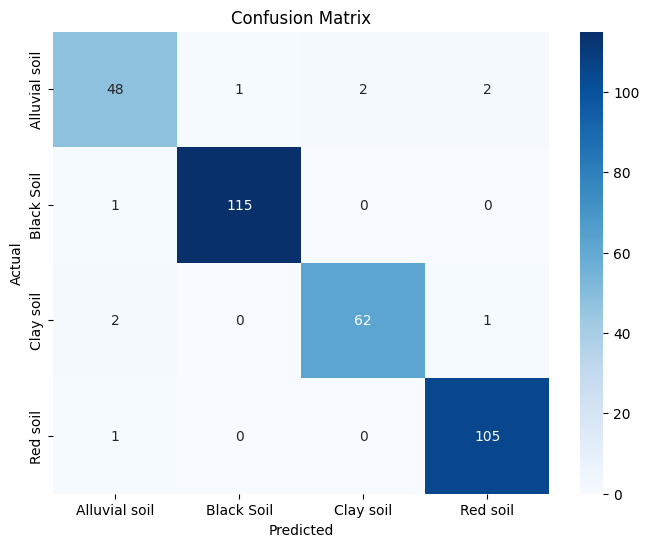

In [12]:
# Confusion Matrix & Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load the Saved Model (For Later Use)
loaded_model = LightSoilNet(num_classes=4).to(device)
loaded_model.load_state_dict(torch.load("lightsoilnet_model.pth", map_location=device))
loaded_model.eval()
print("Model loaded successfully.")

In [ ]:


# Predict a Single Image
def predict_image(image_path, model, class_names):
    image = preprocess_image(image_path)
    transform_pipeline = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform_pipeline(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]
    print(f"Predicted Class: {predicted_class}")
    return predicted_class



In [ ]:
# Example Usage
test_image_path = "/kaggle/input/soil-types-dataset/Dataset/test/Red soil/Copy of images (1).jpg"  
predict_image(test_image_path, loaded_model, train_dataset.classes)
